In [1]:
# imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for dealing with class imbalance
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


# machine learning
from sklearn.model_selection import KFold,cross_val_score,train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


In [2]:
# load data
data=pd.read_csv("wine_quality.csv")
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
# Check the shape
data.shape

(1599, 12)

In [4]:
# rename the columns
data.rename(columns = {'fixed acidity':'fixed_acidity', 
                       'volatile acidity':'volatile_acidity',
                       'citric acid':'citric_acid', 
                       'residual sugar':'residual_sugar',
                       'free sulfur dioxide':'free_sulfur_dioxide',
                       'total sulfur dioxide':'total_sulfur_dioxide'}, inplace = True)

# rename targets
data['quality']=data['quality'].replace({3:0,4:1,5:2,6:3,7:4,8:5})

In [5]:
# check the basic stats
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed_acidity,1599.0,8.319637,1.741096,4.60000,7.1000,7.90000,9.200000,15.90000
volatile_acidity,1599.0,0.527821,0.179060,0.12000,0.3900,0.52000,0.640000,1.58000
citric_acid,1599.0,0.270976,0.194801,0.00000,0.0900,0.26000,0.420000,1.00000
residual_sugar,1599.0,2.538806,1.409928,0.90000,1.9000,2.20000,2.600000,15.50000
chlorides,1599.0,0.087467,0.047065,0.01200,0.0700,0.07900,0.090000,0.61100
free_sulfur_dioxide,1599.0,15.874922,10.460157,1.00000,7.0000,14.00000,21.000000,72.00000
total_sulfur_dioxide,1599.0,46.467792,32.895324,6.00000,22.0000,38.00000,62.000000,289.00000
density,1599.0,0.996747,0.001887,0.99007,0.9956,0.99675,0.997835,1.00369
pH,1599.0,3.311113,0.154386,2.74000,3.2100,3.31000,3.400000,4.01000
sulphates,1599.0,0.658149,0.169507,0.33000,0.5500,0.62000,0.730000,2.00000


In [6]:
# check for data types and nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         1599 non-null   float64
 1   volatile_acidity      1599 non-null   float64
 2   citric_acid           1599 non-null   float64
 3   residual_sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free_sulfur_dioxide   1599 non-null   float64
 6   total_sulfur_dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


2    681
3    638
4    199
1     53
5     18
0     10
Name: quality, dtype: int64


<AxesSubplot:xlabel='quality', ylabel='count'>

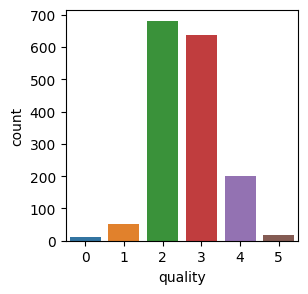

In [7]:
# check class balance
print(data['quality'].value_counts())

# check the balance of the data set
fig = plt.figure(figsize = (3,3))
sns.countplot(x=data["quality"])

Counter({2: 681, 3: 638, 4: 199, 1: 53, 5: 18, 0: 10})
Counter({0: 216, 1: 216, 2: 216, 3: 216, 4: 216, 5: 216})


<AxesSubplot:xlabel='quality', ylabel='count'>

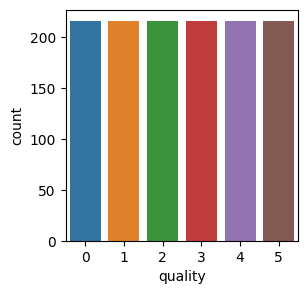

In [12]:
# split the features
X=data.iloc[:,:-1]
y=data.iloc[:,-1]


# summarize class distribution
counter = Counter(y)
print(counter)
# # define pipeline
over = SVMSMOTE(sampling_strategy='auto')
under = RandomUnderSampler(sampling_strategy='auto')
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)


fig = plt.figure(figsize = (3,3))
sns.countplot(x=y)

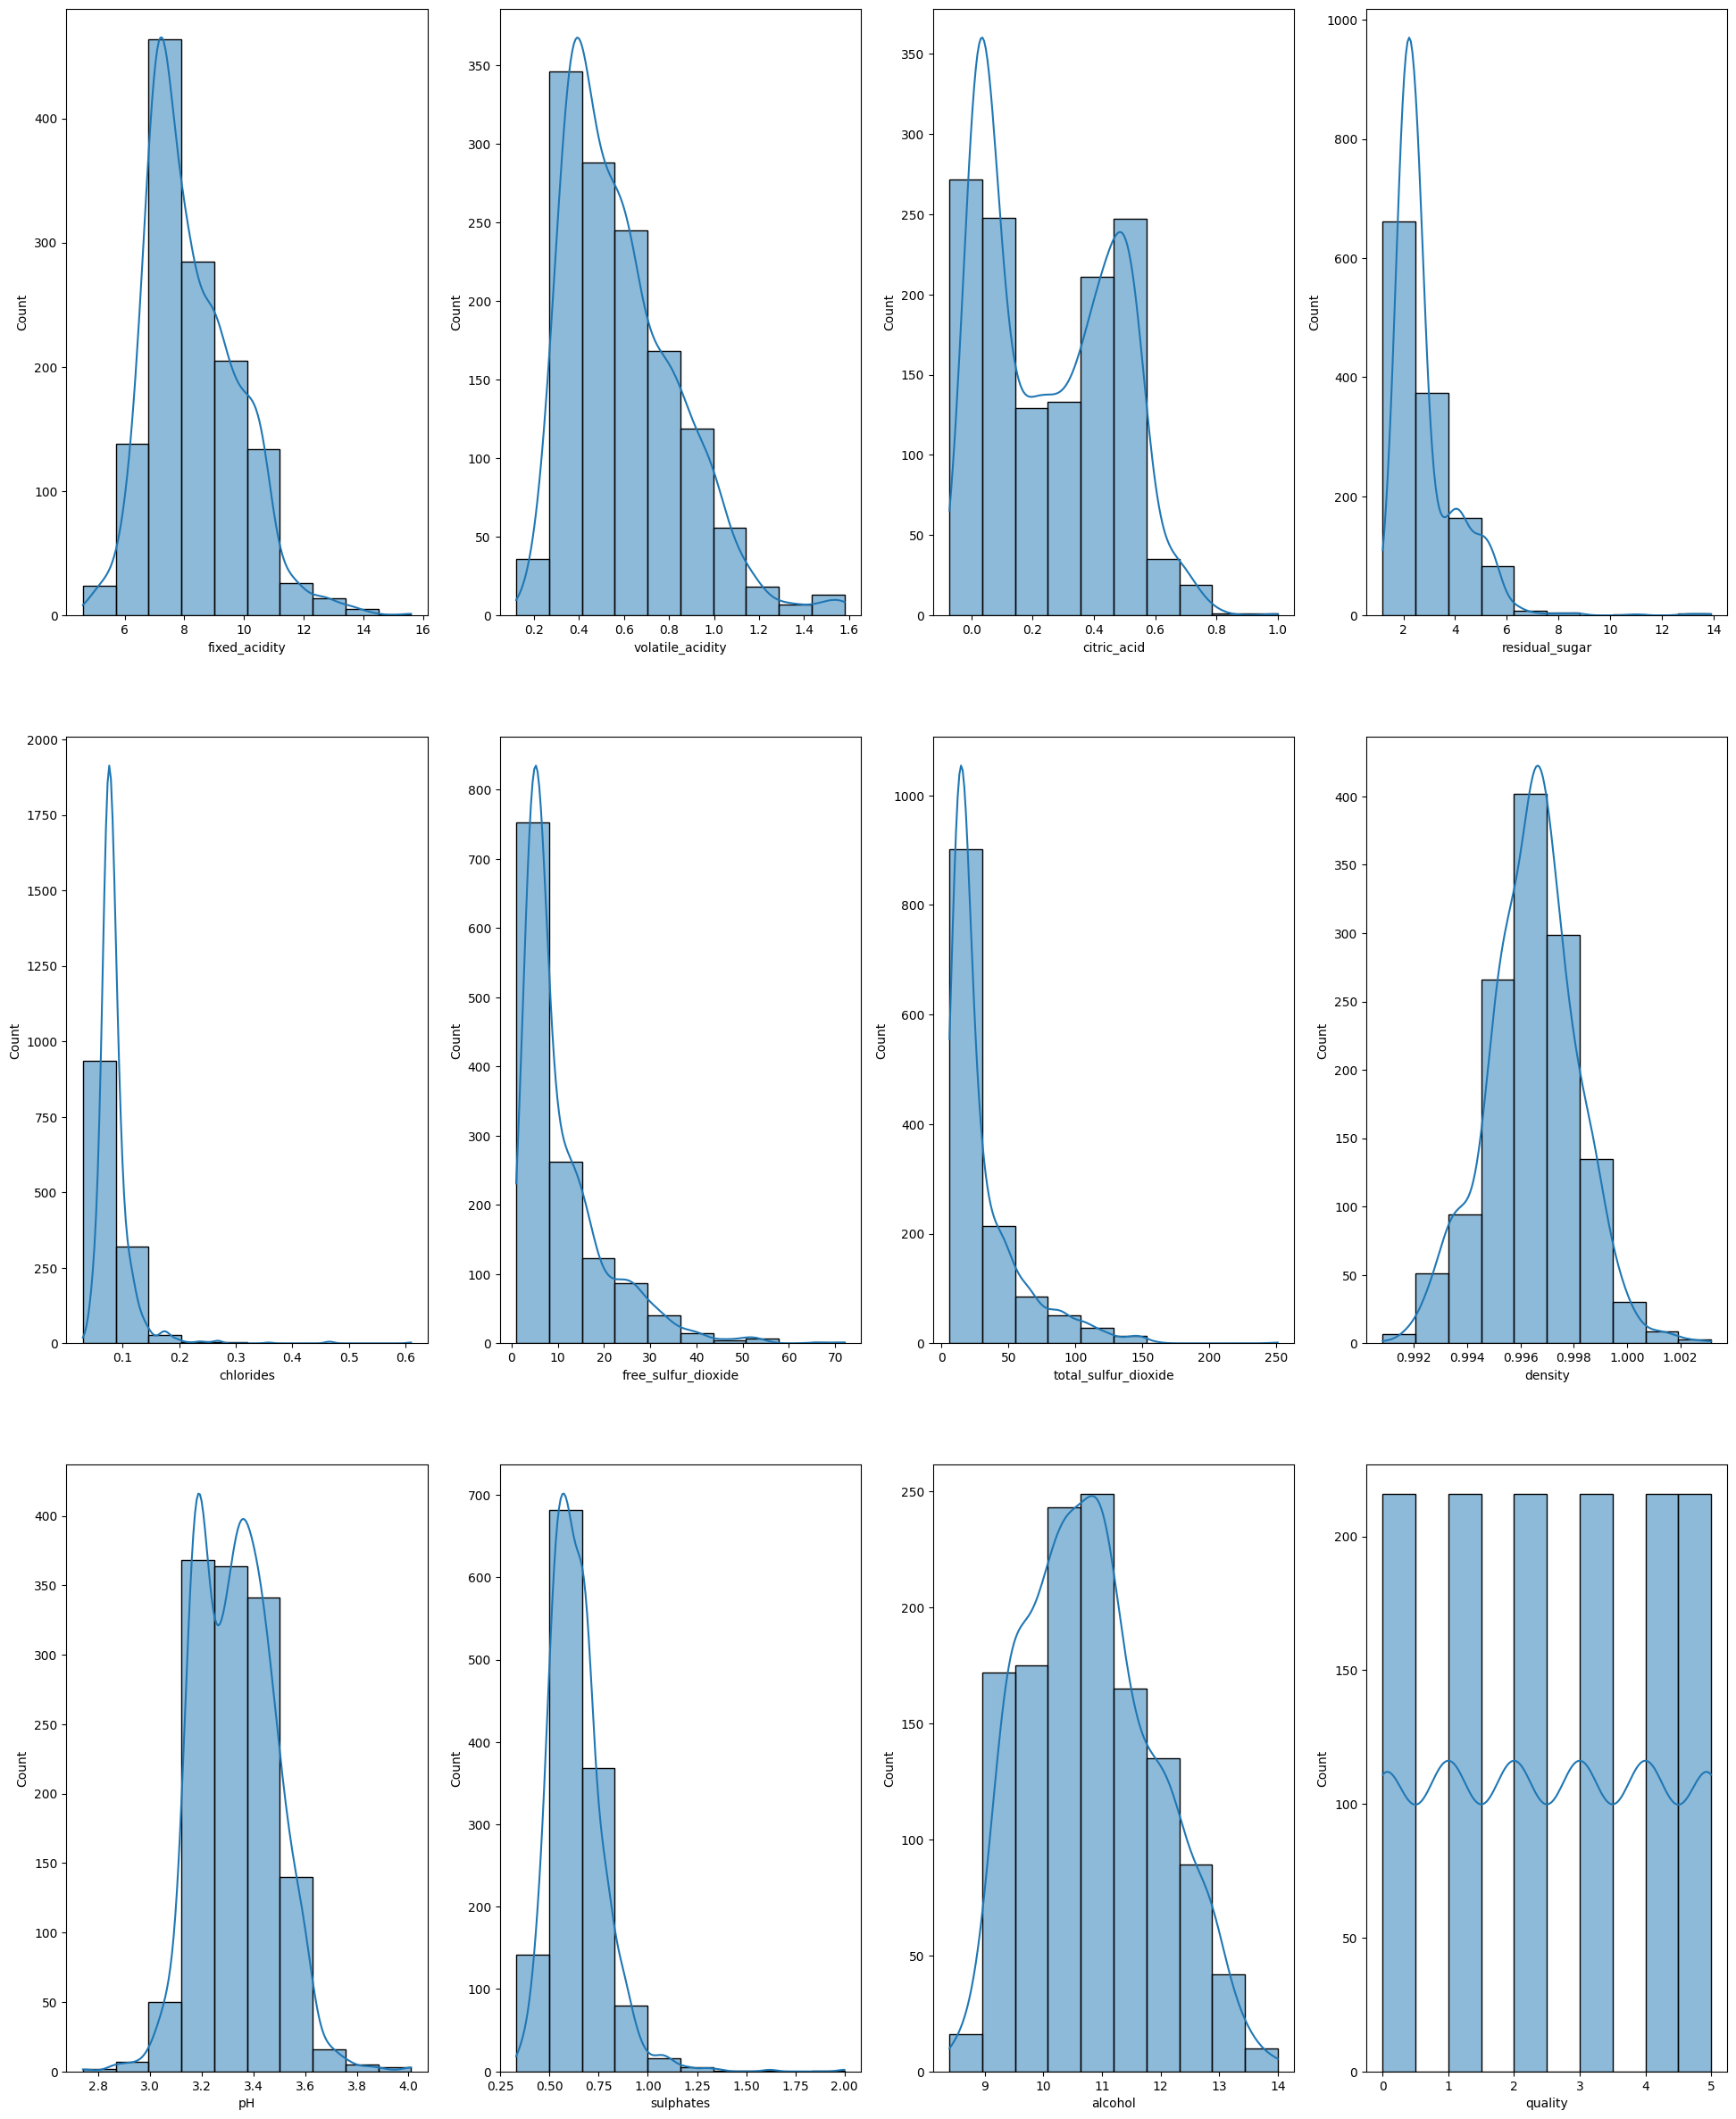

In [14]:
data_balanced=X
data_balanced['quality']=y
# plot the distibution of all the features in the data
# color = sns.color_palette("pastel")
fig, ax1 = plt.subplots(3,4, figsize=(24,30))
k = 0
columns = list(data.columns)
for i in range(3):
    for j in range(4):
            # sns.distplot(data[columns[k]], ax = ax1[i][j], color = 'red')
            sns.histplot(data_balanced[columns[k]],ax=ax1[i][j],bins = 10, kde = True, cbar = True)
            k += 1
plt.show()

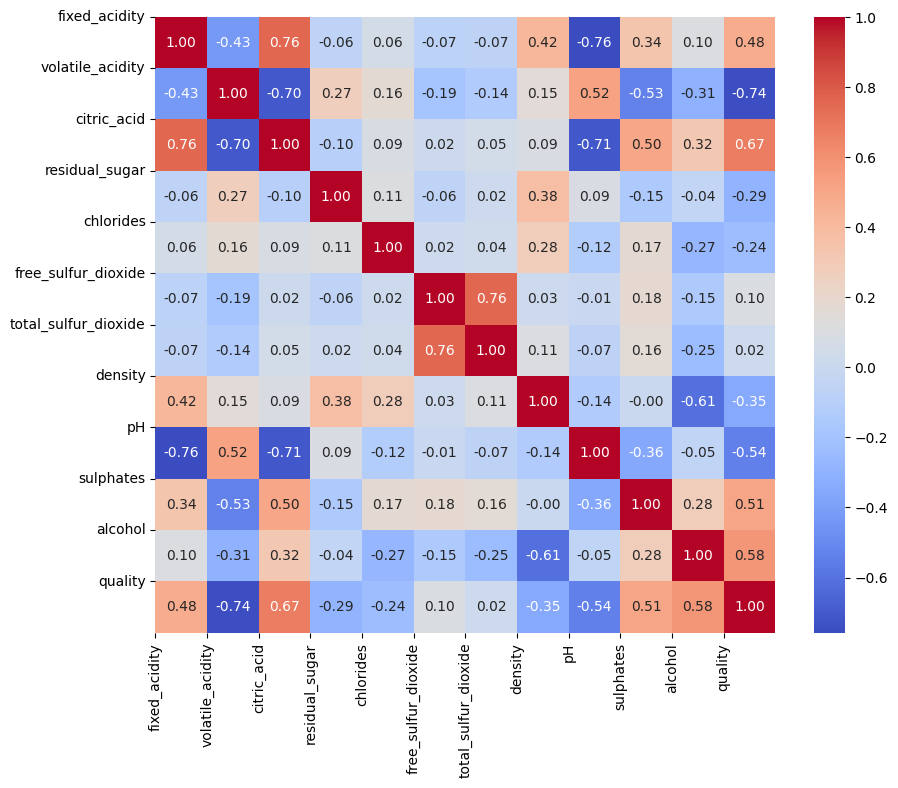

In [15]:
corr = data_balanced.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(10, 8))
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

## Model Building

In [16]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)

# Perform standard scaler for all the independent features
for col in X_train.columns[:-1]:
    sc = StandardScaler().fit(X_train[[col]])
    X_train[col] = sc.transform(X_train[[col]])
    X_test[col] = sc.transform(X_test[[col]])


(868, 12)
(428, 12)


In [17]:
# Initialze the estimators

knn=KNeighborsClassifier()
mnb=MultinomialNB()
lr=LogisticRegression(random_state=42)
sgd=SGDClassifier(random_state=42,loss='log')
svc=SVC(probability=True, random_state=42)
dt=DecisionTreeClassifier(random_state=42)
rf=RandomForestClassifier(random_state=42)
gb=GradientBoostingClassifier(random_state=42)
mlp=MLPClassifier(random_state=42)
xgb_cl=xgb.XGBClassifier(random_state=42)


estimators={"K Nearest neighbors":knn,
            # "Multi Nomial Naive Bayes":mnb,
            "Logitic Regression":lr,
            "SGD":sgd,
            "Support Vectors":svc,
            "Decision Trees":dt,
            "Random Forests":rf,
            "Gradient Boosting":gb,
            "Neural Network":mlp,
            "XGB":xgb_cl}

In [18]:
def fit_multi(X,y,metric):
    results=pd.DataFrame(columns=["Estimator",metric])
    for est in estimators.items():      
        kfold = KFold(n_splits=10,random_state=42,shuffle=True).split(X, y)
        if metric=="accuracy":             
            score = cross_val_score(est[1], X, y, cv= kfold, scoring="accuracy",n_jobs=-1)
            vals=[est[0],score.mean()]                    
        elif metric=="logloss":   
            score = cross_val_score(est[1], X, y, cv= kfold, scoring="neg_log_loss",n_jobs=-1)       
            vals=[est[0],-score.mean()]
        results.loc[len(results)]=vals        
        results.sort_values(by=metric,ascending=False, inplace=True)
    return results

# refitting multiple models
accuracy_results=fit_multi(X_train,y_train,metric='accuracy')
logloss_results=fit_multi(X_train,y_train,metric='logloss')
results=accuracy_results.merge(logloss_results, on='Estimator')
results.sort_values(by='logloss',ascending=True, inplace=True)
results

,Estimator,accuracy,logloss
0,Decision Trees,1.000000,5.289920e-15
1,Gradient Boosting,1.000000,6.793479e-08
2,XGB,1.000000,3.864931e-03
4,Support Vectors,0.987330,5.138525e-02
3,Random Forests,0.994253,1.559161e-01
5,Logitic Regression,0.982692,1.990424e-01
6,Neural Network,0.900949,3.031683e-01
7,K Nearest neighbors,0.872173,8.920926e-01
8,SGD,0.735124,9.682506e-01


In [25]:
clf=DecisionTreeClassifier(random_state=42)
# clf=KNeighborsClassifier()
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
acc=accuracy_score(y_test,y_pred)
cf_matrix = confusion_matrix(y_test, y_pred)
print(acc)

1.0


<AxesSubplot:>

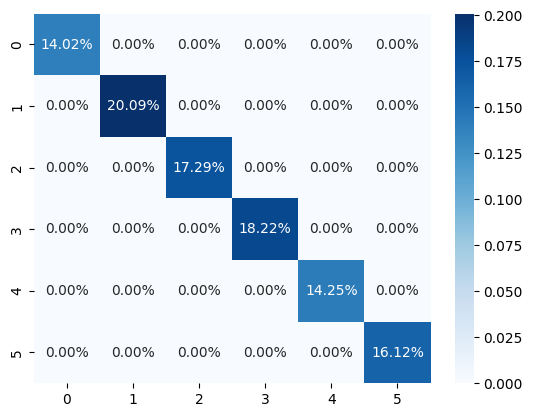

In [26]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')